### Instructions:
1. Use the comments provided to help you.
2. Write code only in the sections indicated by our comments. You can add training hyper-parameters of your choice in the training cells
3. The dataset and trained model folders should be **one level above** your notebook - that is, "../Datasets", "../trained_models" etc.  
   Suggested directory structure:  
   Root Folder/  
     - Datasets/  
     - Models/  
     - Src/  
       - CW2.ipynb  

## Citations
### I used a number of websites to help me with the corusework, i'll list them here. 
---
https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
https://tomroelandts.com/articles/how-to-create-a-simple-low-pass-filter

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.autograd import Variable

from torchvision.utils import save_image
import cv2
import os
import torchvision
import matplotlib.pyplot as plt

## Question 1: Filtering in 1D and 2D
### Part 1a) Implement a filter to remove low frequencies from the audio fileaudio.npy.  Plot the input and outputof your filter as line graphs. **(5 points)**
---
Complete this question by implementing the function `highpass_filter_audio` below, and plotting the output. Reminder: Your implementation of highpass_filter_audioshould only use numpy. You may use other libraries to display your results.

In [6]:
input_audio_filename = "../Datasets/Filtering/audio.npy"

# LOAD input_audio FROM input_audio_filename
input_audio = np.load(input_audio_filename)

In [7]:
def highpass_filter_audio(audio):
    # IMPLEMENT THIS FUNCTION
    highpass_kernel = np.array([-1,2,-1])
    filtered_audio = np.zeros(audio.shape)
    
    for i in range(len(audio) - 2):
        w = np.array([i, i+1, i+2])
        freq_times_kernel = np.multiply(audio[w],highpass_kernel)
        total = np.sum(freq_times_kernel)
        #mean = total / len(highpass_kernel)
        filtered_audio[i] = total
    # iterate through the the audio and get the means and add
    return filtered_audio

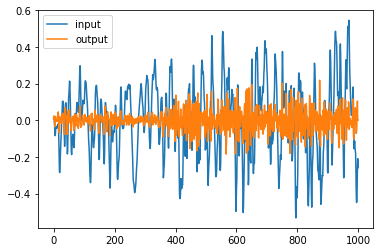

In [8]:
filtered_audio = highpass_filter_audio(input_audio)

# PLOT input_audio AND filtered_audio
times = np.arange(len(input_audio))
plt.plot(times, input_audio, label='input')
plt.plot(times, filtered_audio, label='output')
plt.legend()
plt.show()

### Part 1b) Implement a filter to find vertical edges in an image.  We provide a sample fileimage.pngfor testing. Apply your filter to this image and display the input and output of your filter. **(10 points)**
---
Implement the function `detect_vertical_edges` below. This should apply a filter to detect vertical edges in the supplied input image. That is, your implementation should output a grayscale image of the same width and height as the input, with high values where vertical edges are present in the input image and low values elsewhere. Test your code on the supplied image.png. Display the input image and your output to demonstrate your implementation works correctly. Reminder: Your implementation of detect_vertical_edges should only use numpy. You may use other libraries to display your results.

In [9]:
input_image_filename = "../Datasets/Filtering/image.png"

# LOAD input_image FROM input_image_filename

input_image = cv2.imread(input_image_filename).astype(float) / 255.0

In [10]:
def extend_image(image):
    extended_image = np.zeros((image.shape[0]+2,image.shape[1]+2,image.shape[2]))
    for channel in range(image.shape[2]):
        rgb = image[:,:,channel]
        first_row = rgb[0,:]
        last_row = rgb[-1,:]
        temp = np.vstack((first_row, rgb)) # add a new row to top of image
        temp = np.vstack((temp, last_row))
        first_col = temp[:,0]
        last_col = temp[:,-1]
        temp = np.hstack((first_col.reshape(-1,1), temp))
        temp = np.hstack((temp, last_col.reshape(-1,1)))
        extended_image[:,:,channel] = temp
    return extended_image

def make_gray_scale(image):
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

def detect_vertical_edges(image):
    # IMPLEMENT THIS FUNCTION
    filtered_image = np.zeros(image.shape)
    extended_image = extend_image(image)
    Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    
    for channel in range(image.shape[2]):
        for i in range(1, image.shape[0]):
            for j in range(1, image.shape[1]):
                window = extended_image[i-1:i+2,j-1:j+2,channel]
                conv = np.multiply(Gx,window)
                filtered_image[i-1,j-1,channel] = conv.sum() 
    return filtered_image

def display_image(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.show()

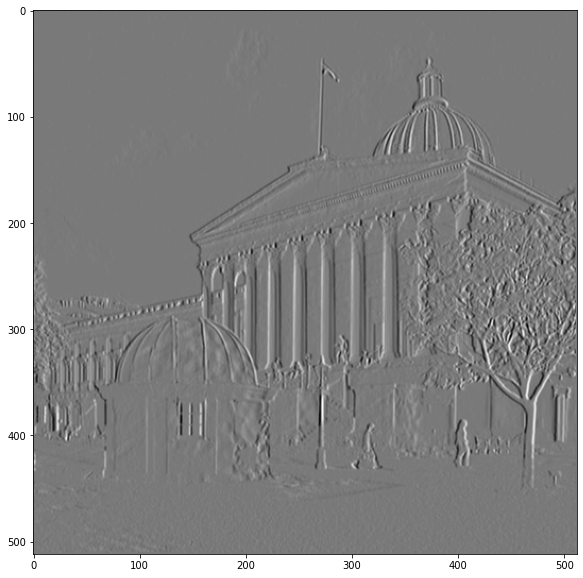

In [11]:
# DISPLAY input_image AND filtered_image here
filtered_image = detect_vertical_edges(input_image)
gray_scale_img = make_gray_scale(filtered_image)

#display_image(input_image)
#display_image(filtered_image)
display_image(gray_scale_img)

## Question 2: Denoising
### Part 2a) Implement denoise_gauss to denoise an image using a 5×5 Gaussian filter.  **(5 points)**
---

Implement the `denoise_gauss` function below. This should apply a 5x5 gaussian filter to a supplied noisy image, returning an output of the same dimensions. Show results on the supplied noisy_image.png.

Reminder: Your implementation for denoise_gauss should only use numpy. You may use other libraries to display your results.

In [11]:
noisy_image_filename = "../Datasets/Filtering/noisy_image.png"

# LOAD noisy_image FROM noisy_image_filename
noisy_image = cv2.imread(noisy_image_filename).astype(float) / 255.0

In [12]:
def denoise_gauss(image):
    # IMPLEMENT THIS FUNCTION
    gaussian_kernel = np.array([[1,4,7,4,1],
                      [4,16,26,16,4],
                      [7,26,41,26,7],
                      [4,16,26,16,4],
                      [1,4,7,4,1]]) * 1/273 # to normalise it so it doesn't affect the pixels in image
    
    padded_image = image
    
    for i in range(0, 2):
        padded_image = extend_image(padded_image)
        
    for channel in range(image.shape[2]):
        for i in range(2, image.shape[0]):
            for j in range(2, image.shape[1]):
                window = padded_image[i-2:i+3,j-2:j+3,channel]
                conv = np.multiply(gaussian_kernel,window)
                padded_image[i-2,j-2,channel] = conv.sum() 
        
    denoised_image = padded_image
    return denoised_image


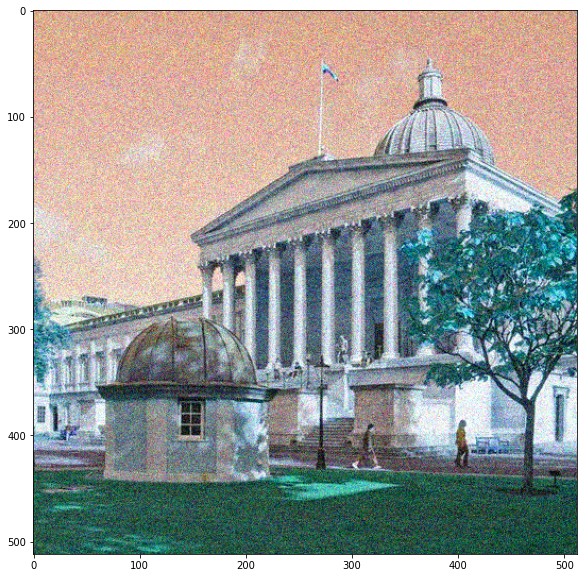

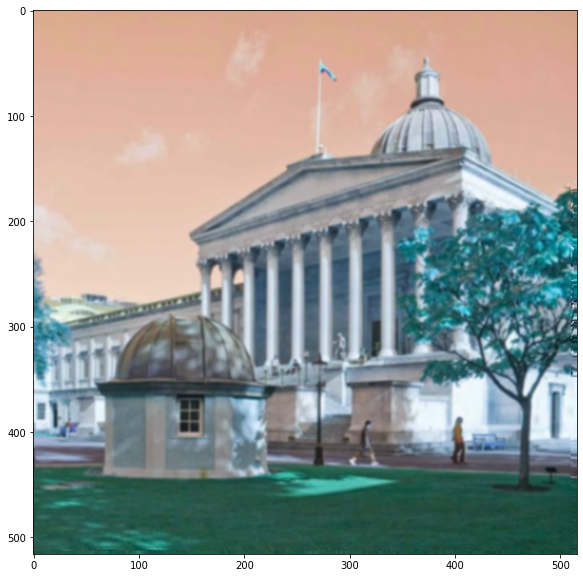

In [13]:
denoised_image = denoise_gauss(input_image)

# DISPLAY input_image AND denoised_image here
display_image(noisy_image)
display_image(denoised_image)

### Part 2b) Implement a pyramidal encoder-decoder to denoise an image.  We provide you pairs of noisy and noise-free image patches of size 128×128 for training and testing. You may use all the infrastructure of Pytorch. The encoder should have 5 levels and double(half) the number of internal activations when reducing (increasing) the spatial resolution. Please use ReLU non-linearities after each layer **(15 points)**
---

Implement following cell, to solve this question.

In [14]:
input_imgs_path = "../Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "../Datasets/Denoising/target_clean_images"
epochs = 150 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

In [10]:
class DenoisingDB(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    # Using code from lab classes to load data
    def __init__(self, input_imgs_path, cleaned_imgs_path=None):
        self.transform = torchvision.transforms.ToTensor()
        
        self.input_imgs_names = sorted(os.listdir(input_imgs_path))
        self.input_imgs_paths = [os.path.join(input_imgs_path, name) for name in self.input_imgs_names]
        
        self.cleaned_imgs_names = sorted(os.listdir(cleaned_imgs_path))
        self.cleaned_imgs_paths = [os.path.join(cleaned_imgs_path, name) for name in self.cleaned_imgs_names]
        
    def __len__(self):
        # RETURN SIZE OF DATASET
        length = len(self.input_imgs_names)
        return length

    # cv2 transforms data into tensors
    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        
        # use cv2 to load images
        input_image = self.transform(cv2.imread(self.input_imgs_paths[idx]))
        output_image = self.transform(cv2.imread(self.cleaned_imgs_paths[idx]))
        
        # reduce the pixel dimensions here so all images are the same size
        input_image = input_image[:, :128, :128]
        output_image = output_image[:, :128, :128]
        return input_image, output_image

class Encoder(Module):
  # IMPLEMENT THIS ENCODER CLASS
    def __init__(self):
        super(Encoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        
        # Reducing the spatial resolution of the image, not strictly doubling from 3 channels however
        self.enc1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self,high_res_image):
        # WRITE YOUR ENCODER ARCHITECTURE HERE
        x = high_res_image
        x = F.relu(self.enc1(x))
        x = (self.bn1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = (self.bn2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = (self.bn3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = (self.bn4(x))
        x = self.pool(x)
        x = F.relu(self.enc5(x))
        x = (self.bn5(x))
        x = self.pool(x) # the latent space representation
        
        low_res_image = x
        
        return low_res_image

class Decoder(Module):
  # IMPLEMENT THIS DECODER CLASS

    def __init__(self):
        super(Decoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        self.dec1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)  
        self.dec2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.out = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self,low_res_image):
        # WRITE YOUR DECODER ARCHITECTURE HERE
        x = low_res_image
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        denoised_image = torch.sigmoid(self.out(x))
        
        return denoised_image

def loss_function(pred,target):
    # WRITE YOUR DENOISING LOSS FUNCTION HERE
    criterion = nn.MSELoss()
    return criterion(pred, target)

In [ ]:
#encode = Encoder()
#decode = Decoder()

optimizer = optim.Adam([{'params': encode.parameters(), 'lr': 1e-3}, {'params': decode.parameters(), 'lr': 1e-3}], lr=1e-3)  

In [ ]:
docs_dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

torch_train_docs = DataLoader(docs_dataset,shuffle=True,batch_size=1,num_workers=0) 

In [236]:
train_loss = []
for ep in range(epochs):
    running_loss = 0.0
    for i,data in enumerate(torch_train_docs):
        img = data[0]
        noisy_img = data[1]
        noisy_img = noisy_img
        optimizer.zero_grad()
        latent_out = encode(img)
        outputs = decode(latent_out)
        loss = loss_function(outputs, noisy_img)
        # back propagation
        loss.backward()
        # update parameters
        optimizer.step()
        running_loss += loss.item()
    
    ## fill in your training loop here. Use the loss function and SGD optimizer
    loss = running_loss / len(torch_train_docs)
    train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')


Epoch 1 of 10, Train Loss: 0.07969
Epoch 2 of 10, Train Loss: 0.05324
Epoch 3 of 10, Train Loss: 0.04624
Epoch 4 of 10, Train Loss: 0.04218
Epoch 5 of 10, Train Loss: 0.03870
Epoch 6 of 10, Train Loss: 0.03406
Epoch 7 of 10, Train Loss: 0.02813
Epoch 8 of 10, Train Loss: 0.02184
Epoch 9 of 10, Train Loss: 0.01709
Epoch 10 of 10, Train Loss: 0.01160


In [ ]:
# Saving models to submit
PATH = "../Models/model_q2.pt"

torch.save({
            'encoder_state_dict': encode.state_dict(),
            'decoder_state_dict': decode.state_dict(),
            }, PATH)

### Part 2c) Write a markdown block, comparing the Gaussian and encoder-decoder denoising methods.  Include example output images from each method and discuss which method performs better and where.  You should write no more than half a page.  **(5 points)**
---

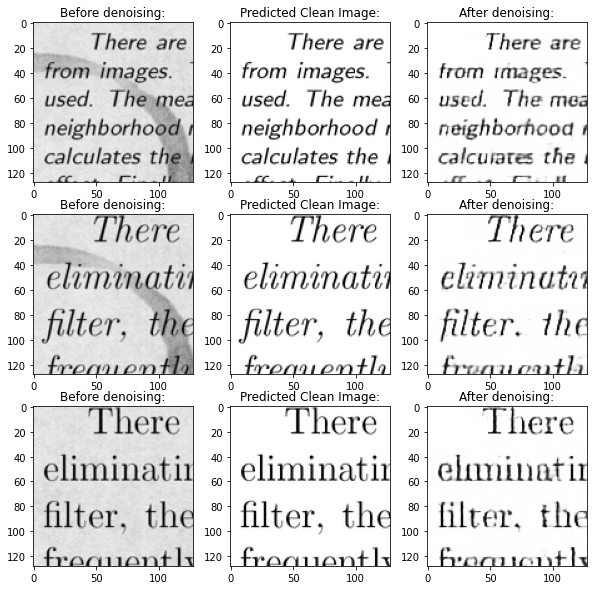

In [237]:
# Code to test model and output it
def test(images):
    plt.figure(figsize=(10,10))
    idx = 0
    for x, y in images:
        show_image(x, idx + 1, "Before denoising:")
        show_image(y, idx + 2, "Predicted Clean Image:")
        out = encode(x)
        out = decode(out)
        show_image(out, idx + 3, "After denoising:")
        idx += 3
        
def show_image(image, idx, label):
    img = image.squeeze().permute(1, 2, 0).detach().numpy()
    plt.subplot(3, 3, idx)
    plt.title(label)
    plt.imshow(img)
    #plt.show()
    
test_loader = DataLoader(docs_dataset,shuffle=True,batch_size=1,num_workers=0)  
test_images = random.sample(list(test_loader), 3)
test(test_images)

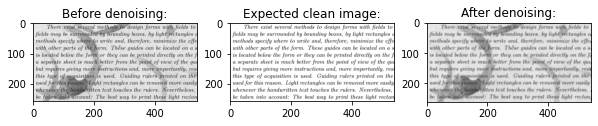

In [23]:
def test(beforeImg, cleanImg, afterImg):
    plt.figure(figsize=(10,10))
    idx = 0
    show_image(beforeImg, idx + 1, "Before denoising:")
    show_image(cleanImg, idx + 2, "Expected clean image:")
    show_image(afterImg, idx + 3, "After denoising:")
        
def show_image(img, idx, label):
    #img = image.squeeze().permute(1, 2, 0).detach().numpy()
    plt.subplot(3, 3, idx)
    plt.title(label)
    plt.imshow(img)
    #plt.show()

input_image_filename = "../Datasets/Denoising/input_noisy_images/2.png"
cleaned_imgs_path = "../Datasets/Denoising/target_clean_images/2.png"

# LOAD input_image FROM input_image_filename

input_image = cv2.imread(input_image_filename).astype(float) / 255.0
clean_image = cv2.imread(cleaned_imgs_path).astype(float) / 255.0

denoised_image = denoise_gauss(input_image)

test(input_image, clean_image, denoised_image)

Firstly, I can see that Encoder-Decoder denoising model appears to perform better than the Gaussian model just from the fact there is a clear distinction between white and black in the ED Denoising model, whilst for Gaussian the images remain grey. Secondly, the gaussian model appears to blur the images rather than focus/sharpen the lettering in the image, to make it much clearer and also fails to remove the grey tea stains from the image. This leads me to believe the gaussian model has a hard time dealing with images with more than one filter, and distinguishing between images with different gradients of the same colour. To conclude, the E-D denoising model performs significantly better.

## Question 3: Auto-Encoder
### Part 3a) Implement a convolutional auto-encoder (AE). The loss between in and output should be L2.  You canmake use of all the convolution, pooling, back-propagation and build-in functionality of Pytorch here. **(15 points)**
---
Solve this question by implementing the AutoEncoder class below

In [30]:
image_size = 100

class AutoEncoder(Module):
    # IMPLEMENT THIS AUTO-ENCODER CLASS
    def __init__(self,bottleneck_size):
        super(AutoEncoder, self).__init__()
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.
        input_shape = image_size**2*3
        self.enc_h1 = nn.Linear(in_features=input_shape, out_features=128)
        self.enc_out = nn.Linear(in_features=128, out_features=bottleneck_size)
        
        self.dec_h1 = nn.Linear(in_features=bottleneck_size, out_features=128)
        self.dec_out = nn.Linear(in_features=128, out_features=input_shape)
        
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        h1_ac = torch.relu(self.enc_h1(image))
        h2_out = self.enc_out(h1_ac)
        code = torch.sigmoid(h2_out)
        return code
    
    def decoder(self,code):
        # WRITE DECODER ARCHITECTURE HERE
        h1_ac = torch.relu(self.dec_h1(code))
        h2_out = self.dec_out(h1_ac)
        decoded_image = torch.sigmoid(h2_out)
        
        return decoded_image
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        decoded_image = self.decoder(code)
        return decoded_image

### Part 3b) Test it on the CelebA and MNIST dataset by encoding and decoding their first 5 samples. Compile results showing for each of the dataset and for each sample the input and the AE reconstruction,side-by-side. **(5 points)**
---
Solve this question by implementing the data classes and your training loop

#### Dataloading Cell - this will be used for both Q3 and Q4

In [31]:
class CelebA(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    def __init__(self, dataset_path=""):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
        self.input_imgs_names = sorted(os.listdir(dataset_path))
        self.input_imgs_paths = [os.path.join(dataset_path, name) for name in self.input_imgs_names]
        
    def __len__(self):
        # RETURN SIZE OF DATASET
        length = len(self.input_imgs_names)
        return length

    # cv2 transforms data into tensors
    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        # use cv2 to load images
        img = cv2.imread(self.input_imgs_paths[idx])
        input_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        input_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        input_image = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_NEAREST)
        input_image = self.transform(input_image)
        return input_image
    
class MNIST(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    def __init__(self, dataset_path=""):
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
        self.input_imgs_names = sorted(os.listdir(dataset_path))
        self.input_imgs_paths = [os.path.join(dataset_path, name) for name in self.input_imgs_names]
    
    def __len__(self):
        # RETURN SIZE OF DATASET
        length = len(self.input_imgs_names)
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        # use cv2 to load images
        img = cv2.imread(self.input_imgs_paths[idx])
        input_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        input_image = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_NEAREST)
        input_image = self.transform(input_image)
        return input_image
    
batch_size = 32
    
celeba_train_data_path = "../Datasets/CelebA/train"
celeba_train_dataset = CelebA(celeba_train_data_path)
torch_train_celeba = DataLoader(celeba_train_dataset,shuffle=True,batch_size=batch_size,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

celeba_validation_data_path = "../Datasets/CelebA/validation"
celeba_validation_dataset = CelebA(celeba_validation_data_path)
torch_validation_celeba = DataLoader(celeba_validation_dataset,shuffle=True,batch_size=batch_size,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_train_data_path = "../Datasets/MNIST/train"
mnist_train_dataset = MNIST(mnist_train_data_path)
torch_train_mnist = DataLoader(mnist_train_dataset,shuffle=True,batch_size=batch_size,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_validation_data_path = "../Datasets/MNIST/validation"
mnist_validation_dataset = MNIST(mnist_validation_data_path)
torch_validation_mnist = DataLoader(mnist_validation_dataset,shuffle=True,batch_size=batch_size,num_workers=1)  # YOU CAN CHOOSE YOUR BATCH SIZE

#### Auto-Encoder training cell

In [32]:
def reconstruction_loss(yPredict, target):
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    criterion = nn.MSELoss()
    return criterion(yPredict, target)

epochs = 3 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

mnist_bottleneck_size = 128 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 128 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

model_mnist = AutoEncoder(mnist_bottleneck_size)
model_celeba = AutoEncoder(celeba_bottleneck_size)

# OPTIMIZER SECTION: USE THE TORCH API TO WRITE YOUR OPTIMIZER FUNCTION BELOW
mnist_optimizer = optim.Adam(model_mnist.parameters(), lr=1e-3) 
celeba_optimizer = optim.Adam(model_celeba.parameters(), lr=1e-3) 

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

train_loss = []
for ep in range(epochs):
    running_loss = 0.0
    for i,data in enumerate(torch_train_celeba):
        # WRITE YOUR CelebA TRAINING LOOP HERE.
        if i >= 1000: break
            
        # reshape mini-batch data to [N, 784] matrix so it can be loaded
        data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
        
        # resetting the gradients back to zero, pytorch accumulates gradients each backward pass
        celeba_optimizer.zero_grad()
        
        # encoder layer pass, compute the reconstructions
        new_img = model_celeba(data)
        
        # compute loss to optimize reconstruction with
        loss = reconstruction_loss(new_img, data)
        
        # back propagation
        loss.backward()
        
        # updtae parameters
        celeba_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        running_loss += loss.item()
    
    loss = running_loss / 1000
    
    #train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')
    
#     count = 0
#     running_loss = 0.0
#     for i,data in enumerate(torch_validation_celeba):
#         # WRITE YOUR CelebA VALIDATION LOOP HERE.
#         if i >= 40:
#             break
#         latent = model_celeba.encoder(data)
#         new_img = model_celeba.decoder(latent)
#         loss = reconstruction_loss(new_img, data)
#         loss.backward()
#         running_loss += loss.item()
#     loss = running_loss / 40
#     train_loss.append(loss)
    
#     if (train_loss[-1] < train_loss[-2]):
#         PATH = "../Models/model_{0}.pt".format(ep)
#         count += 1
#         torch.save(model_celeba.state_dict(), PATH)
    
#     print(f'Epoch {ep+1} of {epochs}, Validation Loss: {loss:.5f}')
    
train_loss = []
for ep in range(epochs):
    running_loss = 0.0
    for i,data in enumerate(torch_train_mnist):
        # WRITE YOUR Mnist TRAINING LOOP HERE.
        if i >= 1000: break
            
        # reshape mini-batch data to [N, 784] matrix so it can be loaded
        data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
        
        # resetting the gradients back to zero, pytorch accumulates gradients each backward pass
        mnist_optimizer.zero_grad()
        
        # encoder layer pass, compute the reconstructions
        new_img = model_mnist(data)
        
        # compute loss to optimize reconstruction with
        loss = reconstruction_loss(new_img, data)
        
        # back propagation
        loss.backward()
        
        # updtae parameters
        mnist_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        running_loss += loss.item()
    
    loss = running_loss / 1000
    
    #train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')
    
#     count = 0
#     running_loss = 0.0
#     for i,data in enumerate(torch_validation_mnist):
#         # WRITE YOUR Mnist VALIDATION LOOP HERE.
#         if i >= 40:
#             break
#         latent = model_mnist.encoder(data)
#         new_img = model_mnist.decoder(latent)
#         loss = reconstruction_loss(new_img, data)
#         loss.backward()
#         running_loss += loss.item()
#     loss = running_loss / 40
#     train_loss.append(loss)
    
#     if (train_loss[-1] < train_loss[-2]):
#         PATH = "../Models/model_mnist{0}.pt".format(ep)
#         count += 1
#         torch.save(model_mnist.state_dict(), PATH)
    
#     print(f'Epoch {ep+1} of {epochs}, Validation Loss: {loss:.5f}')
    

Epoch 1 of 3, Train Loss: 0.04793
Epoch 2 of 3, Train Loss: 0.03514
Epoch 3 of 3, Train Loss: 0.03215
Epoch 1 of 3, Train Loss: 0.05489
Epoch 2 of 3, Train Loss: 0.03283
Epoch 3 of 3, Train Loss: 0.02521


#### Auto-Encoder testing cell

In [33]:
celeba_random_images = random.sample(list(celeba_validation_dataset),5)
celeba_loader = DataLoader(celeba_random_images,shuffle=True,batch_size=1,num_workers=0)

mnist_random_images = random.sample(list(mnist_validation_dataset),5)
mnist_loader = DataLoader(mnist_random_images,shuffle=True,batch_size=1,num_workers=0)

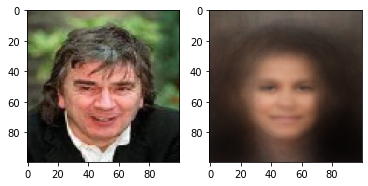

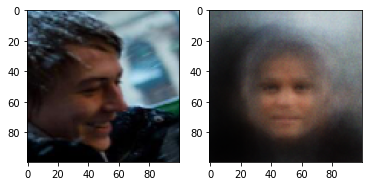

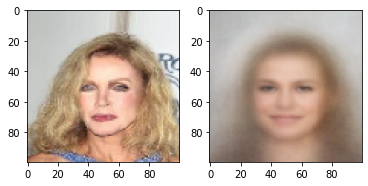

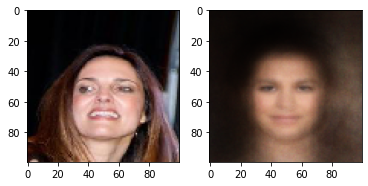

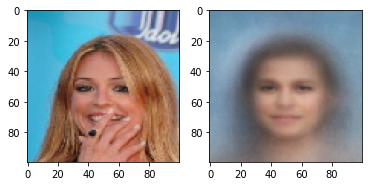

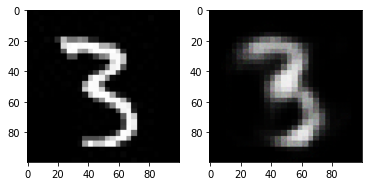

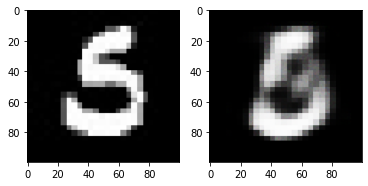

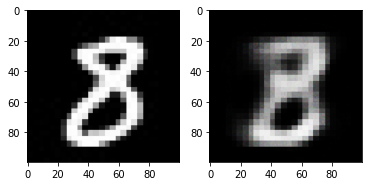

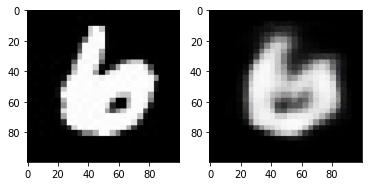

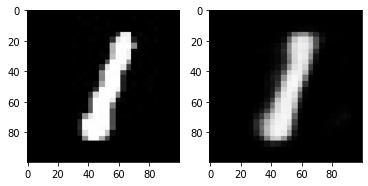

In [144]:
for i, data in enumerate(torch_validation_celeba):
    img_shape = data.shape
    data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
    outputs = model_celeba(data)

    f, axarr = plt.subplots(1,2)
    
    inp_image_tensor = data.reshape(img_shape)
    inp_image = inp_image_tensor.squeeze(0).detach().cpu().numpy()
    inp_image = inp_image[0, :,:,:].transpose(1,2,0)
    
    out_image_tensor = outputs.reshape(img_shape)
    out_image = out_image_tensor.squeeze(0).detach().cpu().numpy()
    out_image = out_image[0, :,:,:].transpose(1,2,0)

    #inp_img = np.array(torchvision.transforms.ToPILImage()(preds))
    axarr[0].imshow(inp_image)
    axarr[1].imshow(out_image)
    if i == 4: break

for i, data in enumerate(torch_validation_mnist):
    img_shape = data.shape
    data = data.view(-1, image_size**2*3)
    outputs = model_mnist(data)

    f, axarr = plt.subplots(1,2)

    inp_image_tensor = data.reshape(img_shape)
    inp_image = inp_image_tensor.squeeze(0).detach().cpu().numpy()
    inp_image = inp_image[0, :,:,:].transpose(1,2,0)
    
    out_image_tensor = outputs.reshape(img_shape)
    out_image = out_image_tensor.squeeze(0).detach().cpu().numpy()
    out_image = out_image[0, :,:,:].transpose(1,2,0)

    #inp_img = np.array(torchvision.transforms.ToPILImage()(preds))
    axarr[0].imshow(inp_image)
    axarr[1].imshow(out_image)
    if i == 4: break

In [145]:
PATH = "../Models/model_q3_mnist.pt"

torch.save(model_mnist.state_dict(), PATH)

In [146]:
PATH_2 = "../Models/model_q3_celeba.pt"

torch.save(model_celeba.state_dict(), PATH_2)

## Question 4: Variational AutoEncoder (VAE)

### Part 4a) Add the reparametrization trick to turn the AE into a variational auto-encoder (VAE) **(15 points)**
---
Solve this question by completing the VAE class below

In [7]:
class VAE(AutoEncoder):
    # IMPLEMENT THIS VAE CLASS
    def __init__(self,bottleneck_size):
        super(VAE, self).__init__(bottleneck_size)
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.
        input_shape = image_size**2*3
        self.enc_h1 = nn.Linear(in_features=input_shape, out_features=128)
        self.mu_h2 = nn.Linear(in_features=128, out_features=bottleneck_size)
        self.logVar_h2 = nn.Linear(in_features=128, out_features=bottleneck_size)
        
        self.dec_h1 = nn.Linear(in_features=bottleneck_size, out_features=128)
        self.dec_out = nn.Linear(in_features=128, out_features=input_shape)
    
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE.
        h1_ac = torch.relu(self.enc_h1(image))
        mu = self.mu_h2(h1_ac)
        logVar = self.logVar_h2(h1_ac)
        std = logVar.mul(0.5).exp_()
        return mu, std
    
    def reparametrization_trick(self, mu, std):
        # WRITE THE REPARAMETRIZATION TRICK HERE.
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        return z
    
    def forward(self, image):
        # PUT IT TOGETHER HERE
        mu, std = self.encoder(image.view(-1, image_size**2*3))
        z = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(z)
        return decoded_image, mu, std

### Part 4b) Test it on the CelebA and MNIST dataset by generating 5 samples of each to be shown in no morethan half a page. **(5 points)**
---

#### VAE training cell

In [17]:
# Loss functions
def kl_divergence_loss(mu,std,batch_size):
    # WRITE YOUR KL-DIVERGENCE LOSS CODE HERE
    # KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    log_var = torch.log(torch.pow(std, 2))
    loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_loss = loss /(batch_size*image_size*2)
    return kl_loss

def reconstruction_loss(yPredict, target):
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    criterion = nn.MSELoss()
    recon_loss = criterion(yPredict, target)
    return recon_loss

def loss_function(yPredict, target, mu, std, batch_size):
    return reconstruction_loss(yPredict, target) + kl_divergence_loss(mu, std, batch_size)

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
epochs = 3 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS
# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE

mnist_bottleneck_size = 128 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 128 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = VAE(mnist_bottleneck_size)
celeba_autoencoder = VAE(celeba_bottleneck_size)

mnist_optimizer = optim.Adam(mnist_autoencoder.parameters(), lr=1e-3) 
celeba_optimizer = optim.Adam(celeba_autoencoder.parameters(), lr=1e-3) 

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
train_loss = 0
for ep in range(epochs):
    loss = 0
    for i,data in enumerate(torch_train_celeba):
        # WRITE YOUR CelebA TRAINING LOOP HERE.
        if i >= 1000: break
            
        # reshape mini-batch data to [N, 784] matrix so it can be loaded
        data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
        
        # resetting the gradients back to zero, pytorch accumulates gradients each backward pass
        celeba_optimizer.zero_grad()
        
        # encoder layer pass, compute the reconstructions
        new_img, mu, std = celeba_autoencoder(data)
        
        # compute loss to optimize reconstruction with
        train_loss = loss_function(new_img, data, mu, std, batch_size)
        
        # back propagation
        train_loss.backward()
        
        # updtae parameters
        celeba_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    loss = loss / 1000
    
    #train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')
    
#     for i,data in enumerate(torch_validation_celeba):
#         # WRITE YOUR CelebA VALIDATION LOOP HERE.
#         if i >= 80:
#             break
#         celeba_optimizer.zero_grad()
#         output, mu, std = celeba_autoencoder.forward(data)
#         loss = loss_function(output, data, mu, std)
#         loss.backward()
#         #celeba_optimizer.step()
#         #print("iteraion: ", i, "loss", loss.item())
#     print("Validation, Epoch ", ep, "LastLoss", loss)

Epoch 1 of 3, Train Loss: 0.44661
Epoch 2 of 3, Train Loss: 0.08196
Epoch 3 of 3, Train Loss: 0.08221


NameError: name 'running_loss' is not defined

In [18]:
train_loss = 0.0
for ep in range(epochs):
    loss = 0.0
    for i,data in enumerate(torch_train_mnist):
        # WRITE YOUR Mnist TRAINING LOOP HERE.
        if i >= 1000: break
            
        # reshape mini-batch data to [N, 784] matrix so it can be loaded
        data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
        
        # resetting the gradients back to zero, pytorch accumulates gradients each backward pass
        mnist_optimizer.zero_grad()
        
        # encoder layer pass, compute the reconstructions
        new_img, mu, std = mnist_autoencoder(data)
        
        # compute loss to optimize reconstruction with
        train_loss = loss_function(new_img, data, mu, std, batch_size)
        
        # back propagation
        train_loss.backward()
        
        # updtae parameters
        mnist_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    loss = loss / 1000
    
    #train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')
    
#     for i,data in enumerate(torch_validation_mnist):
#         if i >= 80:
#             break
#         celeba_optimizer.zero_grad()
#         output, mu, std = mnist_autoencoder.forward(data)
#         loss = loss_function(output, data, mu, std)
#         loss.backward()
#     print("Validation, Epoch ", ep, "LastLoss", loss)

Epoch 1 of 3, Train Loss: 0.06746
Epoch 2 of 3, Train Loss: 0.06742
Epoch 3 of 3, Train Loss: 0.06743


#### VAE testing cell

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


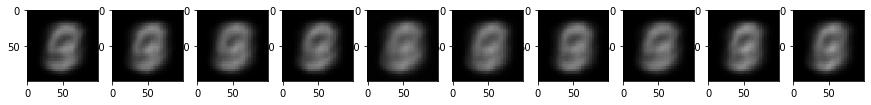

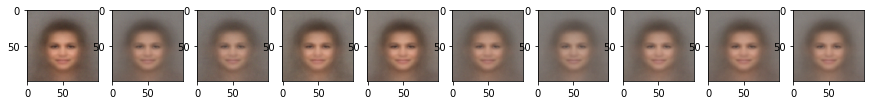

In [25]:
number_of_samples = 10

random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,mnist_bottleneck_size)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_code = random_normal_code
    outputs = mnist_autoencoder.decoder(random_normal_code)
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_mnist_images.append(output_img)

random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_bottleneck_size)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_code = random_normal_code
    outputs = celeba_autoencoder.decoder(random_normal_code)
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_celeba_images.append(output_img)
### Present the images in a single grid of 2x10.
### Top row is for MNIST images, bottom for CelebA
f, axarr = plt.subplots(1,10, figsize=(15,15))
for i, img in enumerate(random_mnist_images):
    axarr[i].imshow(img)
f.show()

f, axarr = plt.subplots(1,10, figsize=(15,15))
for i, img in enumerate(random_celeba_images):
    axarr[i].imshow(img)
f.show()

In [26]:
# Saving models for q4

PATH = "../Models/model_q4_mnist.pt"

torch.save(mnist_autoencoder.state_dict(), PATH)


PATH = "../Models/model_q4_celeba.pt"

torch.save(celeba_autoencoder.state_dict(), PATH)

### Part 4c) Compare the samples from the VAE to the samples of the AE and explain in one sentence what is the difference. **(3 points)**
---
Solve this question by completing and running the cell below with your trained auto-encoder

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


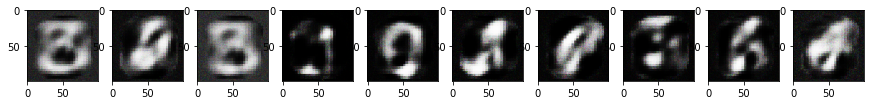

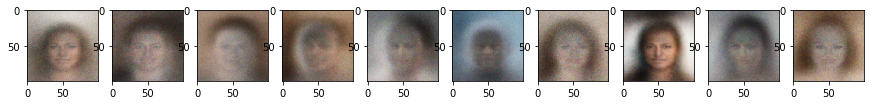

In [34]:
number_of_samples = 10

random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,mnist_bottleneck_size)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_code = random_normal_code
    outputs = model_mnist.decoder(random_normal_code)
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_mnist_images.append(output_img)

random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_bottleneck_size)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_code = random_normal_code
    outputs = model_celeba.decoder(random_normal_code)
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_celeba_images.append(output_img)
### Present the images in a single grid of 2x10.
### Top row is for MNIST images, bottom for CelebA
f, axarr = plt.subplots(1,10, figsize=(15,15))
for i, img in enumerate(random_mnist_images):
    axarr[i].imshow(img)
f.show()

f, axarr = plt.subplots(1,10, figsize=(15,15))
for i, img in enumerate(random_celeba_images):
    axarr[i].imshow(img)
f.show()

From this result I can see that my VAE model performs significantly better than my AE model, the difference is that with my AE there is alot more noise in the resulting encoding. Also there is a lot more variation between the same image, whilst the VAE is more consistent in the copies of images it produces.

### Part 4d) If it is difficult to make VAE optimization converge, please try Stochastic Gradient Descent, and ADAM. Write no more than three sentences and one plot to argue why one optimizer is better than the other while nothing else was changed. **(3 points)**
---

#### Optimizer used - Adam

#### You can modify the optimizer in VAE training cell, and retrain, to make this comparison

### Part 4e) Modify your VAE training to use this VGG Perceptual loss, instead of reconstruction loss.  For this loss,you can use the activation from any of thenlayers of VGG - you can choose your list of VGG layers to use, to generate the best results. **(10 points)**
---
Solve this question by writing the VGG Perceptual Loss in the place indicated below

#### VGG Perceptual Loss definition

In [40]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        vgg = torchvision.models.vgg11(pretrained=True)

        # VGG LAYER SELECTION CODE: YOU CAN USE YOUR CHOICE OF VGG-LAYER TO HELP TRAINING, BY ADDING TO blocks AS ILLUSTRATED BELOW.
        # blocks.append(vgg.features[:2].eval()) # THIS GIVES ACTIVATION OF VGG LAYER 4
        blocks.append(vgg.features[:5].eval()) # THIS GIVES ACTIVATION OF VGG LAYER 9
        blocks.append(vgg.features[5:10].eval()) 
        blocks.append(vgg.features[10:15].eval()) 
        blocks.append(vgg.features[15:20].eval()) 

        for bl in blocks:
            for p in bl:
                p.requires_grad = False

        self.blocks = torch.nn.ModuleList(blocks)

        for bl in self.blocks:
            for p in bl:
                if hasattr(p, "inplace"):
                    p.inplace=False

        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))

    def forward(self, input, target):
        # YOU CAN CHANGE THIS SIZE IF YOU WANT TO, INSTEAD OF 224 x 224. CHOOSE YOUR PARAMETERS TO GENERATE BEST RESULTS.
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)

        vgg_perceptual_loss = 0.0
        
        # WRITE YOUR VGG PERCEPTUAL LOSS CODE HERE
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            vgg_perceptual_loss += torch.nn.functional.l1_loss(x, y)
        return vgg_perceptual_loss

#### Training Cell with VGG Loss

In [ ]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

epochs = 100 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS
# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE

mnist_optimizer = None 
celeba_optimizer = None

mnist_bottleneck_size = 128 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 128 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = VAE(mnist_bottleneck_size)
celeba_autoencoder = VAE(celeba_bottleneck_size)
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

for ep in range(epochs):
    for i,data in enumerate(torch_train_celeba):
        # WRITE YOUR CelebA TRAINING LOOP HERE.
        pass
    
    for i,data in enumerate(torch_validation_celeba):
        # WRITE YOUR CelebA VALIDATION LOOP HERE.
        pass


for ep in range(epochs):
    for i,data in enumerate(torch_train_mnist):
        # WRITE YOUR MNIST TRAINING LOOP HERE.
        pass
    
    for i,data in enumerate(torch_validation_mnist):
        # WRITE YOUR MNIST VALIDATION LOOP HERE.
        pass

#### Testing Cell for VAE with VGG Perceptual Loss

In [ ]:
number_of_samples = 10

random_mnist_images =[]
### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,mnist_bottleneck_size)
    
    ### Use the random code, to generate MNIST images with your trained Variational Auto-Encoder
    
random_celeba_images = []
### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_bottleneck_size)
    
    ### Use the random code, to generate CelebA images with your trained Variational Auto-Encoder
    
### Present the images in a single grid of 2x10.
### Top row is for MNIST images, bottom for CelebA

#### EDIT THIS MARKDOWN TO WRITE ABOUT THE DIFFERENCE BETWEEN SAMPLE GENERATION WITH REGULAR VAE, AND VAE WITH VGG PERCEPTUAL LOSS

### Part 4f) Document a choice of weighting, (α1,...,αn), used above that you think works best for generating new samples.  This should include image examples, arguing for your design **(10 points)**
---

#### EDIT THIS MARKDOWN TO WRITE ABOUT THE WEIGHTING CHOICE USED BY YOU FOR THE VGG LOSS